# My Funny Recursive Fractals

In late 2020 I got in touch with the lovely generative art community. This is such a rich community, with full-time artists, developers, educators, and enthusiasts, who are all in for sharing and learning. These have been great cathalysts for me - even if I myself have taken some forced breaks from arts, I have not stopped following what the community has created.

Generative art joins two different ways of thinking. The first is convergent thinking, which is about making procedures and achieving very definite goals - this is what happens when we try to solve a math problem, for example, or when we learn how to play a song really well. The second is divergent thinking, which is about freely exploring situations and problems - and this is what happens when we start thinking about different ways of solving that same math problem, or when we start improvising over that song.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

## Draw a circle

First, let's draw a circle:

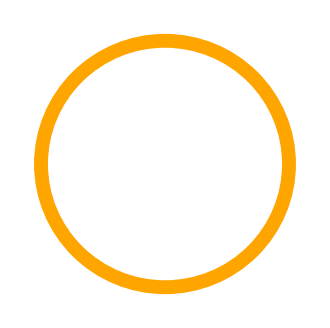

In [2]:
plt.figure(figsize=(4, 4))
circle = plt.Circle(
    (0.5, 0.5),
    0.4,
    color="#ffa500",
    fill=False,
    linewidth=10,
)
plt.gca().add_artist(circle)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis("off")
plt.show()

This is good, but I want to separate the definition of the circle from the function that actually draws it. Maybe I could have something more like:

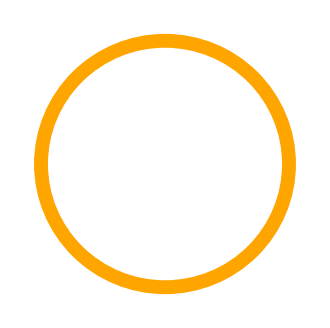

In [3]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False

circle1 = CircleDefinition(
    xy=(0.5, 0.5),
    radius=0.4,
    color="#ffa500",
    linewidth=10,
    fill=False,
)

plt.figure(figsize=(4, 4))
circle = plt.Circle(**circle1.__dict__)
plt.gca().add_artist(circle)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis("off")
plt.show()

One of the beauties of Python is being able to convert the property names within a dataclass directly into function parameter names. This allows us to create a lot of circles and plot them later. Yay for separating models from their visualization.

Now, let's proceed to the actual fractals.

## Complete the frog, I mean, the fractal

Our fractal design is going to work under a recursive definition, which goes like this:

An artwork centered at $(x,y)$ with radius $r$ is a circle centered at $(x,y)$ with radius $r$ plus:

* An artwork centered at $(x+r,y)$ with radius $r/2$
* An artwork centered at $(x-r,y)$ with radius $r/2$
* An artwork centered at $(x,y+r)$ with radius $r/2$
* An artwork centered at $(x,y-r)$ with radius $r/2$

See, we used *artwork* to define *artwork* - a recursive definition. Of course, when the radius is lesser than some threshold, we should stop recursing, as the circles would be too small to make any difference. Our implementation would be like this:

In [4]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False

def recursive_artwork(x, y, radius):
    
    # This is our stop condition
    if radius < 0.1:
        return []
    
    # Now we create the circle at this level
    circle = CircleDefinition(
        xy=(x, y),
        radius=radius,
        color="#ff8530",
        linewidth=1,
        fill=False,
    )
    
    # And we call the function recursively to create smaller circles
    circles = [circle]
    new_radius = radius * 0.5
    circles += recursive_artwork(x + radius, y, new_radius)
    circles += recursive_artwork(x - radius, y, new_radius)
    circles += recursive_artwork(x, y + radius, new_radius)
    circles += recursive_artwork(x, y - radius, new_radius)
    
    return circles

all_circles = recursive_artwork(0, 0, 0.4)

Now, let's plot the circles:

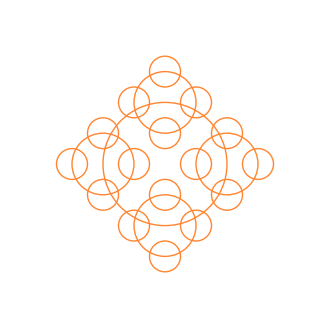

In [5]:
plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis("off")
plt.show()

Things are getting interesting here. Let's make a deeper recursion:

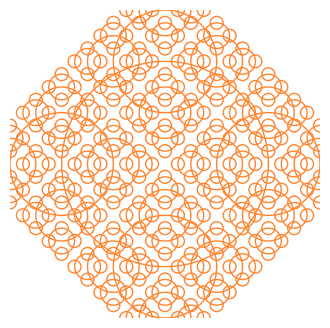

In [6]:
all_circles = recursive_artwork(0, 0, 2)
plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axis("off")
plt.show()


One interesting thing about these recursive structures is that they start displaying patterns and shapes that repeat themselves. Before we spoil everything, let's make some changes in the generation function so that we can have more control:

In [7]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False


def recursive_artwork(
    x: float,
    y: float,
    radius: float,
    min_radius: float = 0.1,
    radius_decay: float = 0.5,
    color: str = "#ff8530",
    linewidth: float = 1,
):
    # This is our stop condition
    if radius < min_radius:
        return []

    # Now we create the circle at this level
    circle = CircleDefinition(
        xy=(x, y),
        radius=radius,
        color=color,
        linewidth=linewidth,
        fill=False,
    )

    # And we call the function recursively to create smaller circles
    circles = [circle]
    new_radius = radius * radius_decay
    circles += recursive_artwork(
        x + radius, y, new_radius, min_radius, radius_decay, color, linewidth
    )
    circles += recursive_artwork(
        x - radius, y, new_radius, min_radius, radius_decay, color, linewidth
    )
    circles += recursive_artwork(
        x, y + radius, new_radius, min_radius, radius_decay, color, linewidth
    )
    circles += recursive_artwork(
        x, y - radius, new_radius, min_radius, radius_decay, color, linewidth
    )

    return circles



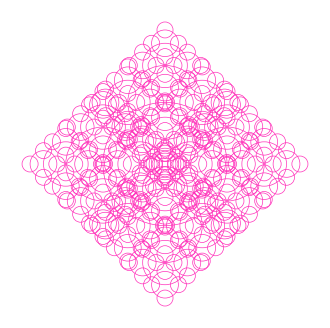

In [8]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.2,
    radius_decay=0.6,
    color="#ff30ba",
    linewidth=0.5,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.show()


## Adding controlled noise

These patterns are really pretty, but I like some irregularities. There are some ways I see we could insert randomness here:

1. Maybe the position of a recursive artwork call is can be randomly shifted,
1. Maybe the system can randomly "forget" to add a particular circle, or
1. Maybe the system can randomly "forget" to go into a recursive call.

Let's work with each one separately.

### Random shifts in the artwork center

A very important aspect here is that one thing is to have randomness while creating the CircleDefinition instance, which is a local thing, or if we want randomness to propagate into the recursive call. Well, let's try both:

In [9]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False


def recursive_artwork(
    x: float,
    y: float,
    radius: float,
    min_radius: float = 0.1,
    radius_decay: float = 0.5,
    color: str = "#ff8530",
    linewidth: float = 1,
    std_dev_local_xy: float = 0.0,
    std_dev_recursive_xy: float = 0.0,
):
    # This is our stop condition
    if radius < min_radius:
        return []

    # Now we create the circle at this level
    circle = CircleDefinition(
        xy=(
            x + std_dev_local_xy * np.random.normal(),
            y + std_dev_local_xy * np.random.normal(),
        ),
        radius=radius,
        color=color,
        linewidth=linewidth,
        fill=False,
    )

    # And we call the function recursively to create smaller circles
    circles = [circle]
    new_radius = radius * radius_decay
    circles += recursive_artwork(
        x + radius + std_dev_recursive_xy * np.random.normal(),
        y + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
    )
    circles += recursive_artwork(
        x - radius + std_dev_recursive_xy * np.random.normal(),
        y + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
    )
    circles += recursive_artwork(
        x + std_dev_recursive_xy * np.random.normal(),
        y + radius + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
    )
    circles += recursive_artwork(
        x + std_dev_recursive_xy * np.random.normal(),
        y - radius + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
    )

    return circles

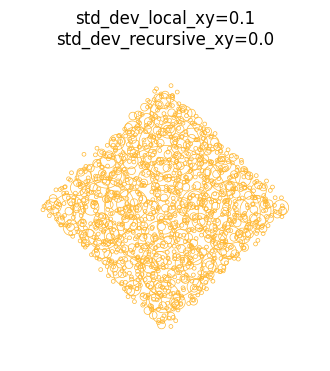

In [10]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.04,
    radius_decay=0.5,
    color="#ffb730",
    linewidth=0.5,
    std_dev_local_xy=0.1,
    std_dev_recursive_xy=0.0,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.title("std_dev_local_xy=0.1\nstd_dev_recursive_xy=0.0")
plt.show()


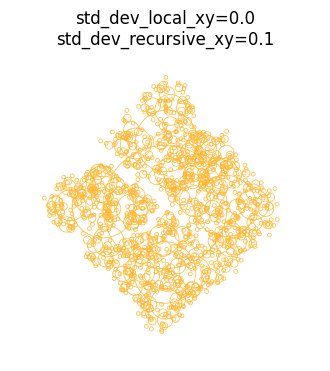

In [11]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.04,
    radius_decay=0.5,
    color="#ffb730",
    linewidth=0.5,
    std_dev_local_xy=0.0,
    std_dev_recursive_xy=0.1,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.title("std_dev_local_xy=0.0\nstd_dev_recursive_xy=0.1")
plt.show()


Noise - either local or at the recursive call - seems to slightly distort that "perfect" pattern. Noise in the recursive call accumulates, which generates more asymetric shapes. Local noise is clearly more visible in the smaller circles.

### Forgetting to add circles

The next step here is to make our system "forget" to add some circles, at random. Let's say a circle will have a probability $p$ of being "forgotten". Then, our function would start looking like this:

In [12]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False


def recursive_artwork(
    x: float,
    y: float,
    radius: float,
    min_radius: float = 0.1,
    radius_decay: float = 0.5,
    color: str = "#ff8530",
    linewidth: float = 1,
    std_dev_local_xy: float = 0.0,
    std_dev_recursive_xy: float = 0.0,
    p_skip_circle: float = 0.0,
):
    # This is our stop condition
    if radius < min_radius:
        return []

    # Now we create the circle at this level
    if np.random.uniform() < p_skip_circle:
        circles =  []
    else:
        circle = CircleDefinition(
            xy=(
                x + std_dev_local_xy * np.random.normal(),
                y + std_dev_local_xy * np.random.normal(),
            ),
            radius=radius,
            color=color,
            linewidth=linewidth,
            fill=False,
        )
        circles = [circle]

    new_radius = radius * radius_decay
    circles += recursive_artwork(
        x + radius + std_dev_recursive_xy * np.random.normal(),
        y + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
        p_skip_circle=p_skip_circle,
    )
    circles += recursive_artwork(
        x - radius + std_dev_recursive_xy * np.random.normal(),
        y + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
        p_skip_circle=p_skip_circle,
    )
    circles += recursive_artwork(
        x + std_dev_recursive_xy * np.random.normal(),
        y + radius + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
        p_skip_circle=p_skip_circle,
    )
    circles += recursive_artwork(
        x + std_dev_recursive_xy * np.random.normal(),
        y - radius + std_dev_recursive_xy * np.random.normal(),
        new_radius,
        min_radius,
        radius_decay,
        color,
        linewidth,
        std_dev_local_xy,
        std_dev_recursive_xy,
        p_skip_circle=p_skip_circle,
    )

    return circles

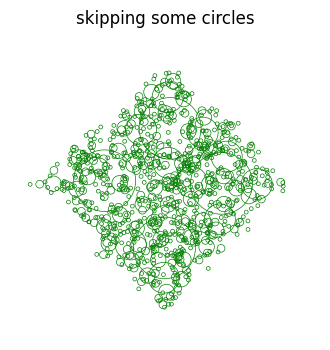

In [13]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.04,
    radius_decay=0.5,
    color="#058103",
    linewidth=0.5,
    std_dev_local_xy=0.0,
    std_dev_recursive_xy=0.1,
    p_skip_circle=0.3,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.title("skipping some circles")
plt.show()


It looks great - of course, the circle density has decreased! What if we forgot to recurse into whole branches? Then we would get this:

In [14]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = False


def recursive_artwork(
    x: float,
    y: float,
    radius: float,
    min_radius: float = 0.1,
    radius_decay: float = 0.5,
    color: str = "#ff8530",
    linewidth: float = 1,
    std_dev_local_xy: float = 0.0,
    std_dev_recursive_xy: float = 0.0,
    p_skip_circle: float = 0.0,
    p_skip_branch: float = 0.0,
):
    # This is our stop condition
    if radius < min_radius:
        return []

    # Now we create the circle at this level
    if np.random.uniform() < p_skip_circle:
        circles =  []
    else:
        circle = CircleDefinition(
            xy=(
                x + std_dev_local_xy * np.random.normal(),
                y + std_dev_local_xy * np.random.normal(),
            ),
            radius=radius,
            color=color,
            linewidth=linewidth,
            fill=False,
        )
        circles = [circle]

    new_radius = radius * radius_decay
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + radius + std_dev_recursive_xy * np.random.normal(),
            y + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )
        
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x - radius + std_dev_recursive_xy * np.random.normal(),
            y + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )
        
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + std_dev_recursive_xy * np.random.normal(),
            y + radius + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )

    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + std_dev_recursive_xy * np.random.normal(),
            y - radius + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )

    return circles

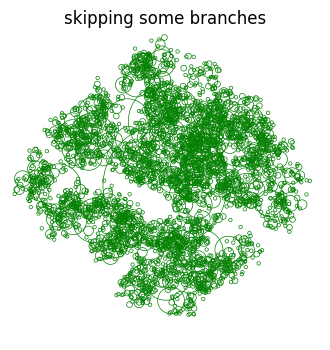

In [15]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.04,
    radius_decay=0.6,
    color="#058103",
    linewidth=0.5,
    std_dev_local_xy=0.0,
    std_dev_recursive_xy=0.1,
    p_skip_circle=0.3,
    p_skip_branch=0.2,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.title("skipping some branches")
plt.show()


Now we are getting into something cool! Let's add fill and alpha to our circles:

In [16]:
@dataclass
class CircleDefinition:
    xy: tuple
    radius: float
    color: str
    linewidth: float
    fill: bool = True
    alpha: float = 0.2


def recursive_artwork(
    x: float,
    y: float,
    radius: float,
    min_radius: float = 0.1,
    radius_decay: float = 0.5,
    color: str = "#ff8530",
    linewidth: float = 1,
    std_dev_local_xy: float = 0.0,
    std_dev_recursive_xy: float = 0.0,
    p_skip_circle: float = 0.0,
    p_skip_branch: float = 0.0,
):
    # This is our stop condition
    if radius < min_radius:
        return []

    # Now we create the circle at this level
    if np.random.uniform() < p_skip_circle:
        circles =  []
    else:
        circle = CircleDefinition(
            xy=(
                x + std_dev_local_xy * np.random.normal(),
                y + std_dev_local_xy * np.random.normal(),
            ),
            radius=radius,
            color=color,
            linewidth=linewidth,
            fill=True,
        )
        circles = [circle]

    new_radius = radius * radius_decay
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + radius + std_dev_recursive_xy * np.random.normal(),
            y + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )
        
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x - radius + std_dev_recursive_xy * np.random.normal(),
            y + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )
        
    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + std_dev_recursive_xy * np.random.normal(),
            y + radius + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )

    if np.random.uniform() > p_skip_branch:
        circles += recursive_artwork(
            x + std_dev_recursive_xy * np.random.normal(),
            y - radius + std_dev_recursive_xy * np.random.normal(),
            new_radius,
            min_radius,
            radius_decay,
            color,
            linewidth,
            std_dev_local_xy,
            std_dev_recursive_xy,
            p_skip_circle=p_skip_circle,
            p_skip_branch=p_skip_branch,
        )

    return circles

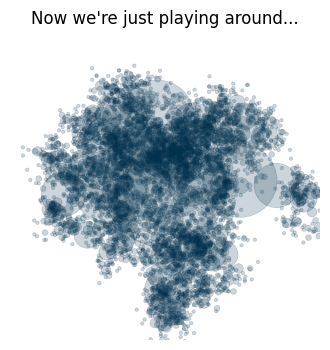

In [19]:
all_circles = recursive_artwork(
    x=0,
    y=0,
    radius=2,
    min_radius=0.04,
    radius_decay=0.6,
    color="#02314E",
    linewidth=0.5,
    std_dev_local_xy=0.0,
    std_dev_recursive_xy=0.2,
    p_skip_circle=0.2,
    p_skip_branch=0.2,
)

plt.figure(figsize=(4, 4))
for circle in all_circles:
    circle_artist = plt.Circle(**circle.__dict__)
    plt.gca().add_artist(circle_artist)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis("off")
plt.title("Now we're just playing around...")
plt.show()


## We now have something!

We slowly went from that determininstic recursive pattern to these very interesting forms which reminds of an ink stain - all because we added some controlled noises to the appropriate places. For a while, I want to play with the parameters and see what else I can make with this same structure. Anyway, I hope these funny recursive (and somewhat random) fractals sparked some ideas for you too! Let's keep exploring and creating!